In [2]:
# this is the CUAHSI API endpoint
# http://his.cuahsi.org/wofws.html
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

In [3]:
#Install directly from github repo main branch
#%pip install -q git+https://github.com/ulmo-dev/ulmo.git
import ulmo

In [5]:
# import packages, had some issues importing/installing geopandas and contextily, but got it eventually

import os

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [5]:
# identify SNOTEL site locations
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [6]:
# convert to pandas dataframe from dictionary and drop na values
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()

In [7]:
# clean up dataframe and prepare point geometry objects, need x and y locs
# do this by creating a new column (geometry) and pulling lat and long info and use Point package to pull info from dict
sites_df['geometry']=[Point(float(loc['longitude']),float(loc['latitude'])) for loc in sites_df['location']]
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({'elevation_m':float})

In [8]:
# gathers all snotel sites
sites_gdf_all = gpd.GeoDataFrame(sites_df, crs='EPSG:4326')
# gathers all snotel sites in Washington
css_snotel = sites_gdf_all[sites_gdf_all['name'] == 'Css Lab']

In [9]:
# snow and swe variables
met_vars = ['SNOTEL:SNWD_H','SNOTEL:WTEQ_H']
today = datetime.today().strftime('%Y-%m-%d')
# function will take in a sitecode, variable code, start and end date and return variable data for that range and location as df
def snotel_fetch(sitecode, variablecode, start_date='1950-01-01', end_date=today):
    values_df = None
    sitename = 'Null'
    try:
        # start by requesting data from the server
        #print('Requesting Data from Server...')
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl,sitecode, variablecode, start=start_date, end=end_date)
        # return name of station
        sitename = site_values['site']['name']
        # convert to pandas dataframe
        values_df = pd.DataFrame.from_dict(site_values['values'])
        # parse the datetime values to Pandas Timestamp object
        #print('Cleaning Data...')
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=False) # turned to false for excel export
        # set df index to datetime
        values_df = values_df.set_index('datetime')
        # convert values to float and replace -9999 with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999,np.nan)
        # rename values column after variable code
        values_df.rename(columns = {'value':variablecode}, inplace = True)
        # remove lower quality records
        values_df = values_df[values_df['quality_control_level_code']=='1'][variablecode] 
        print('Done!')
    except:
        print('Unable to fetch %s' % variablecode)
    return values_df, sitename

In [10]:
# gets station output for specified stations
def getStation_output(sitecode, start, end, variables=met_vars):
    site_snotel = pd.DataFrame()
    sitename = 'Null'
    for var in variables:
        print('Fetching {0} for {1}'.format(var, sitecode))
        tmp, sitename = snotel_fetch(sitecode,var,start_date=start,end_date=end)
        if (tmp is not None) and (site_snotel is not None):
            site_snotel[var] = tmp
        else:
            site_snotel = None
    return site_snotel, sitename

In [11]:
site_code = 'SNOTEL:428_CA_SNTL' # for muckamuck station
start, end = '2016-11-15', '2017-06-15' # change dates if desired
outpath = None # change path to preferred output location
# outputs two dataframes, one for depth and the other for swe
cssl, sitename = getStation_output(site_code, start, end)

Fetching SNOTEL:SNWD_H for SNOTEL:428_CA_SNTL
Done!
Fetching SNOTEL:WTEQ_H for SNOTEL:428_CA_SNTL
Done!


In [54]:
cssl_mm = cssl * 25.4

SNOTEL:SNWD_H  SNOTEL:WTEQ_H
           datetime                              
2016-11-15 0                   0.0           0.00
           1                   0.0          -2.54
           2                   0.0          -2.54
           3                   0.0          -2.54
           4                  25.4          -2.54
...                            ...            ...
2017-06-14 20                  0.0          93.98
           21                  0.0          93.98
           22                 25.4          91.44
           23                  0.0          91.44
2017-06-15 0                   0.0           0.00

[4731 rows x 2 columns]

In [55]:
cssl_mm.index.names = ['DateTime', 'DateTime']

In [69]:
cssl_mm.groupby(cssl_mm.index.get_level_values(0)).count()

,SNOTEL:SNWD_H,SNOTEL:WTEQ_H
DateTime,,
2016-11-15,24,24
2016-11-16,20,20
2016-11-17,19,19
2016-11-18,24,24
2016-11-19,22,22
...,...,...
2017-06-11,21,21
2017-06-12,18,18
2017-06-13,24,24


In [56]:
fn2 = r"C:\Users\dlhogan\Downloads\428_26_WATERYEAR=2017.csv"
cssl = pd.read_csv(fn2, skiprows=2)

In [57]:
cssl = cssl.groupby('Date').median()
cssl.index.name = 'DateTime'
cssl.index = pd.to_datetime(cssl.index, utc=False)
cssl_mm = cssl[(cssl.index >= '2016-11-15') & (cssl.index <= '2017-06-15')]
cssl_mm = cssl_mm.rename(columns={'WTEQ.I-1 (in) ':'SWE_SNOTEL'})
cssl_mm = cssl_mm[cssl_mm['SWE_SNOTEL']>=0]
cssl_mm = cssl_mm.sort_index()


In [58]:
cssl_mm

,Site Id,SWE_SNOTEL
DateTime,,
2016-11-16,428.0,0.10
2016-11-17,428.0,0.30
2016-11-18,428.0,0.00
2016-11-19,428.0,0.00
2016-11-20,428.0,2.30
...,...,...
2017-06-11,428.0,4.30
2017-06-12,428.0,4.60
2017-06-13,428.0,4.05


In [59]:
cssl_mm['SWE_SNOTEL'] = cssl_mm['SWE_SNOTEL']*25.4 
cssl_mm = cssl_mm[cssl_mm['SWE_SNOTEL']<=1000]

In [60]:
fn = r"C:\Users\dlhogan\OneDrive - UW\Documents\winter-quarter-2022\WY2017_CSSL_alpine_hydromet.csv"
alpine_hydromet_2017 = pd.read_csv(fn)

In [61]:
alpine_hydromet_2017['DateTime'] = pd.to_datetime(alpine_hydromet_2017['DateTime'], utc=False)

idx = alpine_hydromet_2017['DateTime']
alpine_hydromet_2017_D = alpine_hydromet_2017.groupby([idx.dt.date]).median()
alpine_hydromet_2017_H = alpine_hydromet_2017.groupby([idx.dt.date, idx.dt.hour]).mean()

In [62]:
fn3 =r"C:\Users\dlhogan\Downloads\Whole_WY_2017.csv"
cssl_manual = pd.read_csv(fn3,parse_dates=['Date'], index_col=['Date'])

In [63]:
cssl_manual.index.name = 'DateTime'
cssl_manual_mm = cssl_manual[(cssl_manual.index >= '2016-11-15') & (cssl_manual.index <= '2017-06-15')]
cssl_manual_mm = cssl_manual_mm.rename(columns={'Snow Water Equivalent (cm)':'SWE_manual'})
cssl_manual_mm.index = pd.to_datetime(cssl_manual_mm.index, utc=False)
cssl_manual_mm['SWE_manual'] = cssl_manual_mm['SWE_manual'].replace(to_replace='--', value=np.nan)
cssl_manual_mm['SWE_manual'] = pd.to_numeric(cssl_manual_mm['SWE_manual'])
cssl_manual_mm['SWE_manual'] = cssl_manual_mm['SWE_manual']*10

In [64]:
if 'FSP9_mm' not in cssl_mm.columns:
    cssl_mm = cssl_mm.join(alpine_hydromet_2017_D)

In [65]:
cssl_mm = cssl_mm.join(cssl_manual_mm)

Text(0.5, 1.0, 'SWE Comparison - CSSL 2016-2017')

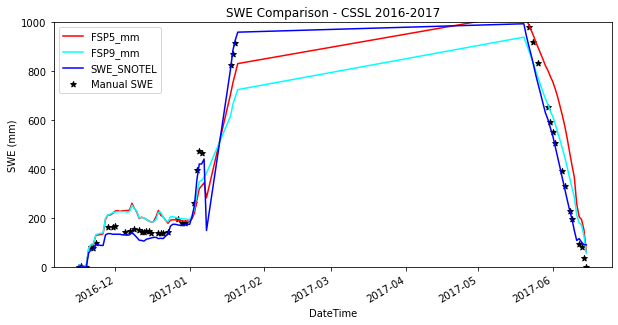

In [66]:
fig, ax = plt.subplots(figsize=(10,5));
cssl_mm.plot(y='FSP5_mm', ax=ax, color='r');
cssl_mm.plot(y='FSP9_mm', ax=ax, color='cyan');
ax.scatter(x=cssl_mm.index, y=cssl_mm['SWE_manual'], label='Manual SWE', marker='*',color='k');
cssl_mm.plot(y='SWE_SNOTEL', ax=ax, c='b');
ax.legend()
ax.set_ylabel('SWE (mm)')
ax.set_ylim(0,1000)
ax.set_title('SWE Comparison - CSSL 2016-2017')

In [67]:
(cssl_mm['SWE_SNOTEL'] - cssl_mm['FSP9_mm']).describe()

count     85.000000
mean     -41.496615
std       79.437321
min     -234.531523
25%      -92.600627
50%      -56.999818
75%      -17.279664
max      234.677903
dtype: float64

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms1 = sqrt(mean_squared_error(cssl_mm['SWE_SNOTEL'], cssl_mm['FSP9_mm']))
rms1

89.20772620958114

In [69]:
rms2 = sqrt(mean_squared_error(cssl_mm['SWE_SNOTEL'], cssl_mm['FSP5_mm']))
rms2

119.80122863041251